In [148]:
import torch 
import seaborn as sns
import torch.nn.functional as F
import numpy as np
import scipy

In [2]:
model = torch.load('/home/sidd_s/scratch/saved_models/Protoseg/hrnet_w48_proto_lr1x_hrnet_proto_80k_latest.pth')

In [3]:
protos=model['state_dict']['module.prototypes']

### self similarity between intra protos...mostly same!

In [12]:
feat=protos.view(-1,protos.shape[-1])

In [13]:
feat.shape

torch.Size([190, 720])

In [18]:
simi=feat @ feat.t() # self similarity like covariance 

In [19]:
simi=simi.cpu().numpy()

<Axes: >

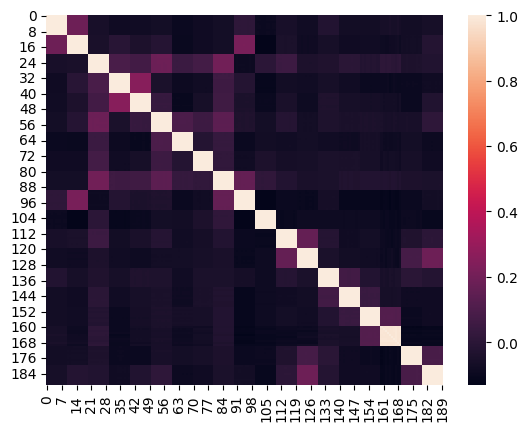

In [21]:
sns.heatmap(simi)

In [22]:
print(simi[0,:10])

[1.         1.0000001  1.         0.99999994 1.         0.99999994
 1.         1.         1.         0.99999994]


In [23]:
print(simi[100,100:110])

[1.        0.9999995 0.9999992 0.9999996 0.9999981 0.9999997 0.9999988
 0.9999991 0.9999997 0.9999998]


In [24]:
simi.shape

(190, 190)

### semantic similarity between protos (different class)

In [26]:
protos.shape

torch.Size([19, 10, 720])

In [53]:
protos[0].shape

torch.Size([10, 720])

In [49]:
cs = torch.mm(protos[0], protos[1].T)

In [50]:
cs.shape

torch.Size([10, 10])

In [52]:
# cs

In [54]:
protos[0][0].shape

torch.Size([720])

In [56]:
cs = torch.matmul(protos[0][0], protos[1][0].T)

In [57]:
cs

tensor(0.1859, device='cuda:0')

In [58]:
cs = torch.matmul(protos[0][0], protos[2][0].T)

In [59]:
cs

tensor(-0.0557, device='cuda:0')

In [60]:
cs = torch.matmul(protos[0][0], protos[3][0].T)

In [61]:
cs

tensor(-0.0825, device='cuda:0')

In [119]:
protos[0][0]

torch.Size([10, 720])

In [120]:
cos = torch.nn.CosineSimilarity(dim=0)

In [132]:
cos(protos[0][0], protos[1][0]) # cosine similarity

tensor(0.1859, device='cuda:0')

In [133]:
cos(protos[0][0], protos[10][0])

tensor(-0.0939, device='cuda:0')

In [129]:
(protos[0][0] - protos[10][0]).pow(2).sum().sqrt()

tensor(1.4791, device='cuda:0')

In [130]:
(protos[0][0] - protos[1][0]).pow(2).sum().sqrt() 

tensor(1.2760, device='cuda:0')

In [131]:
# torch.cdist(protos[0][0], protos[1][0], p=2) # l2 norm

In [50]:
def similarity_among_classes(protos):
    similarity_matrix = []
    for i in range(19):
        per_row_similarity = [] 
        for j in range(19):
            per_row_similarity.append(cos(protos[i][0], protos[j][0]))
        similarity_matrix.append(per_row_similarity)
    similarity_matrix_tensor = torch.FloatTensor(similarity_matrix)    
    return similarity_matrix_tensor

In [51]:
similarity_matrix_tensor = similarity_among_classes(protos)

In [52]:
similarity_matrix_tensor.shape

torch.Size([19, 19])

<Axes: >

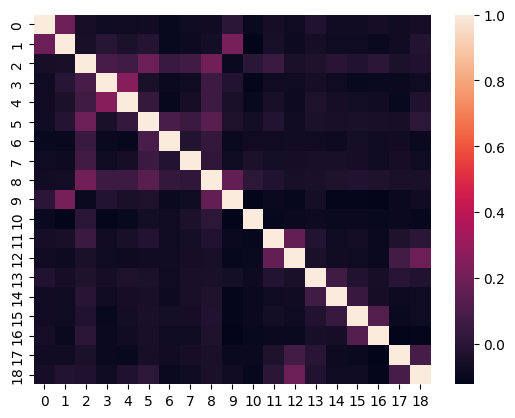

In [53]:
sns.heatmap(similarity_matrix_tensor)

In [99]:
similarity_matrix_tensor[0]

tensor([ 1.0000,  0.1859, -0.0557, -0.0825, -0.0768, -0.0707, -0.0972, -0.0813,
        -0.0714,  0.0081, -0.0939, -0.0581, -0.0793, -0.0245, -0.0735, -0.0734,
        -0.0615, -0.0730, -0.0598])

In [100]:
similarity_matrix_tensor[1]

tensor([ 0.1859,  1.0000, -0.0508, -0.0081, -0.0419, -0.0177, -0.1009, -0.0844,
        -0.0684,  0.2169, -0.1229, -0.0500, -0.0846, -0.0609, -0.0815, -0.0794,
        -0.0882, -0.0720, -0.0197])

In [63]:
# similarity_matrix_tensor.sum(0) # symmetric

In [65]:
# similarity_matrix_tensor.sum(1) # symmetric

In [101]:
sim_test = similarity_matrix_tensor.clone()

In [118]:
# sim_test.fill_diagonal_(-1e17) ## filling extremely low numbers at diagonals for removing them from similarity consideration

In [104]:
sim_test[1]

tensor([ 1.8595e-01, -1.0000e+17, -5.0757e-02, -8.1064e-03, -4.1885e-02,
        -1.7750e-02, -1.0093e-01, -8.4441e-02, -6.8405e-02,  2.1688e-01,
        -1.2291e-01, -5.0037e-02, -8.4630e-02, -6.0888e-02, -8.1468e-02,
        -7.9393e-02, -8.8206e-02, -7.1955e-02, -1.9714e-02])

In [105]:
sim_test.shape

torch.Size([19, 19])

In [ ]:
## applying softmax to convert into probability distribution 

In [106]:
probas_sim_test = F.softmax(sim_test, dim=1)

In [107]:
probas_sim_test.shape

torch.Size([19, 19])

In [113]:
probas_sim_test[0]

tensor([0.0000, 0.0703, 0.0552, 0.0538, 0.0541, 0.0544, 0.0530, 0.0538, 0.0544,
        0.0589, 0.0532, 0.0551, 0.0540, 0.0570, 0.0543, 0.0543, 0.0549, 0.0543,
        0.0550])

In [112]:
probas_sim_test[1]

tensor([0.0690, 0.0000, 0.0545, 0.0568, 0.0549, 0.0563, 0.0518, 0.0527, 0.0535,
        0.0712, 0.0507, 0.0545, 0.0526, 0.0539, 0.0528, 0.0529, 0.0525, 0.0533,
        0.0562])

In [116]:
probas_sim_test.sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [93]:
# pn = F.normalize(probas_sim_test, p=2, dim=1)  # not required, as they are already normalised along the rows

In [191]:
def similarity_among_classes(protos):
    cos = torch.nn.CosineSimilarity(dim=0)
    similarity_matrix = []
    for i in range(19):
        per_row_similarity = [] 
        for j in range(19):
            per_row_similarity.append(cos(protos[i][0], protos[j][0]))
        similarity_matrix.append(per_row_similarity)
    similarity_matrix_tensor = torch.FloatTensor(similarity_matrix)     

    # sim_test = similarity_matrix_tensor.clone() 
    # sim_test.fill_diagonal_(-1e17) ## filling extremely low numbers at diagonals for removing them from similarity consideration
    # probas_sim_test = F.softmax(sim_test, dim=1) ## applying softmax to convert into probability distribution 

    # return probas_sim_test, similarity_matrix_tensor
    return similarity_matrix_tensor

In [192]:
# probas_sim_test, similarity_matrix_tensor = similarity_among_classes(protos)
similarity_matrix_tensor = similarity_among_classes(protos)

In [145]:
# probas_sim_test_prev = probas_sim_test # using clone in above function, instead of multiplying with 100

In [148]:
similarity_matrix_tensor[10]

tensor([-0.0939, -0.1229,  0.0013, -0.1112, -0.0990, -0.0702, -0.0752, -0.0438,
         0.0121, -0.1232,  1.0000, -0.1026, -0.0883, -0.0859, -0.0890, -0.0894,
        -0.0996, -0.0932, -0.1049])

In [193]:
similarity_matrix_tensor[10]

tensor([-0.0939, -0.1229,  0.0013, -0.1112, -0.0990, -0.0702, -0.0752, -0.0438,
         0.0121, -0.1232,  1.0000, -0.1026, -0.0883, -0.0859, -0.0890, -0.0894,
        -0.0996, -0.0932, -0.1049])

In [142]:
# (similarity_matrix_tensor[0] + 1) / 2

In [186]:
probas_sim_test.sum(1) # passing the requirement

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [150]:
probas_sim_test_prev.sum(1) # passing the requirement

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [151]:
probas_sim_test.sum(0)

tensor([4.3535e-02, 1.9957e+00, 3.0985e+00, 1.0000e+00, 1.0001e+00, 1.2780e+00,
        3.6465e-04, 2.8259e-03, 1.6040e+00, 9.7825e-01, 9.2556e-06, 9.7142e-02,
        2.2772e+00, 9.0589e-01, 9.9903e-01, 1.0933e+00, 9.9937e-01, 9.8066e-04,
        1.6259e+00])

In [152]:
probas_sim_test_prev.sum(0)

tensor([0.9858, 1.0062, 1.0625, 1.0006, 1.0118, 1.0373, 0.9791, 0.9912, 1.0561,
        0.9912, 0.9532, 0.9989, 1.0022, 0.9990, 0.9818, 0.9861, 0.9706, 0.9829,
        1.0036])

In [115]:
similarity_matrix_tensor[0][9]

tensor(0.0081)

In [112]:
similarity_matrix_tensor[0][10]

tensor(-0.0939)

In [113]:
probas_sim_test[0][9]

tensor(1.8947e-08)

In [114]:
probas_sim_test[0][10]

tensor(7.0194e-13)

In [153]:
similarity_matrix_tensor[10]

tensor([-0.0939, -0.1229,  0.0013, -0.1112, -0.0990, -0.0702, -0.0752, -0.0438,
         0.0121, -0.1232,  1.0000, -0.1026, -0.0883, -0.0859, -0.0890, -0.0894,
        -0.0996, -0.0932, -0.1049])

In [159]:
probas_sim_test[10]

tensor([0.0457, 0.0342, 0.1184, 0.0384, 0.0434, 0.0579, 0.0551, 0.0754, 0.1319,
        0.0341, 0.0000, 0.0419, 0.0483, 0.0495, 0.0480, 0.0478, 0.0431, 0.0460,
        0.0409])

In [161]:
probas_sim_test_prev[10] # nothing as the multiplicative factor 

tensor([0.0549, 0.0533, 0.0604, 0.0539, 0.0546, 0.0562, 0.0559, 0.0577, 0.0610,
        0.0533, 0.0000, 0.0544, 0.0552, 0.0553, 0.0551, 0.0551, 0.0546, 0.0549,
        0.0543])

In [174]:
probas_sim_test[5]

tensor([8.5071e-12, 1.6971e-09, 9.8822e-01, 9.0125e-11, 3.1960e-07, 0.0000e+00,
        1.3772e-04, 1.7405e-06, 1.1638e-02, 2.3947e-10, 8.9912e-12, 1.5227e-09,
        6.7356e-12, 1.7648e-10, 7.1231e-11, 1.0738e-10, 6.7966e-11, 3.7696e-11,
        2.3333e-08])

In [189]:
probas_sim_test[4]

tensor([0.0527, 0.0546, 0.0610, 0.0737, 0.0000, 0.0589, 0.0513, 0.0537, 0.0604,
        0.0544, 0.0516, 0.0540, 0.0522, 0.0549, 0.0536, 0.0532, 0.0530, 0.0517,
        0.0552])

In [187]:
similarity_matrix_tensor[4]

tensor([-0.0768, -0.0419,  0.0687,  0.2576,  1.0000,  0.0346, -0.1032, -0.0590,
         0.0588, -0.0450, -0.0990, -0.0519, -0.0872, -0.0369, -0.0610, -0.0668,
        -0.0716, -0.0970, -0.0305])

In [188]:
# for i in range(19):
#     print(probas_sim_test[i].max())

In [72]:
probas_sim_test[0][1] # sidewalk when 10 use as multiplicative factor

tensor(0.4141)

In [70]:
probas_sim_test[0][12] # rider when 10 use as multiplicative factor

tensor(0.0292)

In [71]:
probas_sim_test[0][10] # sky when 10 use as multiplicative factor

tensor(0.0252)

In [80]:
probas_sim_test[0][1] # sidewalk when 100 use as multiplicative factor

tensor(1.)

In [81]:
probas_sim_test[0][12] # rider when 100 use as multiplicative factor

tensor(3.0191e-12)

In [82]:
probas_sim_test[0][10] # sky when 100 use as multiplicative factor

tensor(7.0194e-13)

In [41]:
probas_sim_test.sum(0)

tensor([4.3535e-02, 1.9957e+00, 3.0985e+00, 1.0000e+00, 1.0001e+00, 1.2780e+00,
        3.6465e-04, 2.8259e-03, 1.6040e+00, 9.7825e-01, 9.2556e-06, 9.7142e-02,
        2.2772e+00, 9.0589e-01, 9.9903e-01, 1.0933e+00, 9.9937e-01, 9.8066e-04,
        1.6259e+00])

In [42]:
probas_sim_test.sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [18]:
similarity_matrix_tensor[1]

tensor([ 0.1859,  1.0000, -0.0508, -0.0081, -0.0419, -0.0177, -0.1009, -0.0844,
        -0.0684,  0.2169, -0.1229, -0.0500, -0.0846, -0.0609, -0.0815, -0.0794,
        -0.0882, -0.0720, -0.0197])

In [26]:
similarity_matrix_tensor.max()

tensor(1.0000)

In [27]:
similarity_matrix_tensor.min()

tensor(-0.1232)

In [137]:
torch.log(torch.tensor((0.1859, 0.2169))) 

tensor([-1.6825, -1.5283])

In [138]:
torch.exp(torch.tensor((0.1859, 0.2169))) 

tensor([1.2043, 1.2422])

In [24]:
-torch.log(torch.tensor((0.0197, 0.0720)))

tensor([3.9271, 2.6311])

<Axes: >

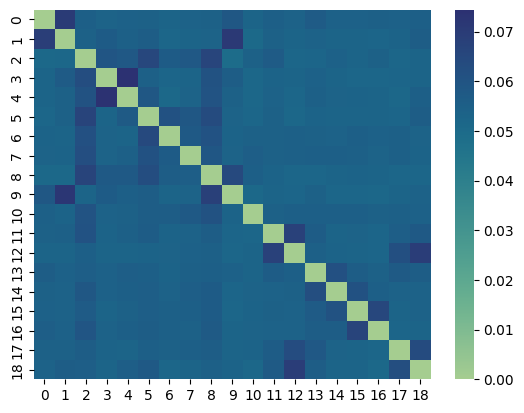

In [15]:
sns.heatmap(probas_sim_test, cmap="crest")

<Axes: >

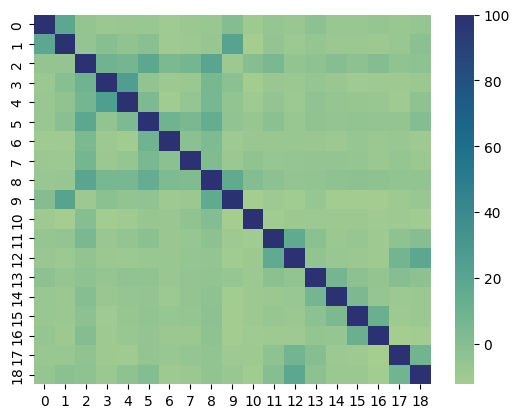

In [16]:
sns.heatmap(similarity_matrix_tensor*100, cmap="crest")

In [28]:
similarity_matrix_tensor_inper = similarity_matrix_tensor * 100

In [29]:
similarity_matrix_tensor_inper.max()

tensor(100.0000)

In [30]:
similarity_matrix_tensor_inper.min()

tensor(-12.3211)

In [32]:
similarity_matrix_tensor_inper[1]

tensor([ 18.5950, 100.0000,  -5.0757,  -0.8106,  -4.1885,  -1.7750, -10.0927,
         -8.4441,  -6.8405,  21.6880, -12.2911,  -5.0037,  -8.4630,  -6.0888,
         -8.1468,  -7.9393,  -8.8206,  -7.1955,  -1.9714])

In [139]:
torch.log(torch.tensor((18.59, 21.68)))

tensor([2.9226, 3.0764])

In [140]:
torch.exp(torch.tensor((18.59, 21.68)))

tensor([1.1845e+08, 2.6032e+09])

In [35]:
torch.exp(torch.tensor((-0.0197, -0.0720)))

tensor([0.9805, 0.9305])

### calculating adjacency matrix knn from similarity matrix

In [4]:
def similarity_among_classes(protos):
    cos = torch.nn.CosineSimilarity(dim=0)
    similarity_matrix = []
    for i in range(19):
        per_row_similarity = [] 
        for j in range(19):
            per_row_similarity.append(cos(protos[i][0], protos[j][0]))
        similarity_matrix.append(per_row_similarity)
    similarity_matrix_tensor = torch.FloatTensor(similarity_matrix)     

    # sim_test = similarity_matrix_tensor.clone() 
    # sim_test.fill_diagonal_(-1e17) ## filling extremely low numbers at diagonals for removing them from similarity consideration
    # probas_sim_test = F.softmax(sim_test, dim=1) ## applying softmax to convert into probability distribution 

    # return probas_sim_test, similarity_matrix_tensor
    return similarity_matrix_tensor

In [5]:
similarity_matrix_tensor = similarity_among_classes(protos)

In [6]:
similarity_matrix_tensor.shape

torch.Size([19, 19])

In [7]:
similarity_matrix_tensor[0]

tensor([ 1.0000,  0.1859, -0.0557, -0.0825, -0.0768, -0.0707, -0.0972, -0.0813,
        -0.0714,  0.0081, -0.0939, -0.0581, -0.0793, -0.0245, -0.0735, -0.0734,
        -0.0615, -0.0730, -0.0598])

In [6]:
similarity_matrix = np.array(similarity_matrix_tensor)

In [8]:
# demo = np.arange(9).reshape(3, 3)
# demo

# # np.sum(demo, axis=1) 

# # np.diag(demo)

# # np.diagonal(demo)

# np.diag(np.sum(demo, axis = 1))





# demo_tr = demo - np.diag(np.sum(demo, axis=1)) ## transition rate matrix

# demo_tr.shape

# demo_tr

# demo_tr.sum(1)

In [9]:
ind_2_class_dict = {  
    0: "Road",
    1: "Sidewalk", 
    2: "Building",  
    3: "wall",
    4: "fence",  
    5: "Pole", 
    6: "Traffic light",
    7: "Traffic sign",
    8: "Vegetation", 
    9: "Terrain",
    10: "Sky",
    11: "Person",
    12: "Rider",
    13: "Car",
    14: "Truck",
    15: "Bus",
    16: "Train",
    17: "Motorcycle",
    18: "Bicycle"
}

In [10]:
similarity_matrix[0]

array([ 1.        ,  0.18594968, -0.05567453, -0.08249253, -0.07682546,
       -0.07070753, -0.09718965, -0.08125065, -0.07142282,  0.00813339,
       -0.09389959, -0.05807469, -0.07931101, -0.02446502, -0.07346708,
       -0.07344367, -0.06149413, -0.07296647, -0.05980625], dtype=float32)

In [11]:
# first_row_sim_decrease = np.argsort(similarity_matrix[0])[::-1]

# first_row_sim_decrease

# k_nn = 3 

# knn_inds = first_row_sim_decrease[:k_nn]
# knn_inds

# knn_val = similarity_matrix[0][knn_inds]
# knn_val

# for i in range(knn_inds.shape[0]):
#     print(knn_inds[i], ind_2_class_dict[knn_inds[i]])

# sim_mat = similarity_matrix.copy()

# sim_mat[0][knn_inds]  = 1

# sim_mat[0]

# sim_mat[0][sim_mat[0]!=1] = 0 

# sim_mat[0]

In [12]:
# sim_mat = similarity_matrix.copy()
# k_nn = 3
# similar_classes = []
# for row in range(sim_mat.shape[0]):
#         row_sim_decrease_inds = np.argsort(sim_mat[row])[::-1]
#         knn_indexs = row_sim_decrease_inds[:k_nn]    
#         sim_mat[row][knn_indexs] = 1
#         sim_mat[row][sim_mat[row]!=1] = 0
        
#         similar_classes.append([ (('Current Class:' + ind_2_class_dict[row]) ,(knn_indexs[i], ind_2_class_dict[knn_indexs[i]])) for i in range(knn_indexs.shape[0])])

In [13]:
# len(similar_classes)

# # similar_classes

# sim_mat.shape

In [97]:
# sim_mat

In [41]:
def calculate_adjacency_matrix_knn(similarity_matrix, k): 
    adj = similarity_matrix.copy()
    similar_classes = []
    for row in range(adj.shape[0]):
        row_sim_decrease_inds = np.argsort(adj[row])[::-1]
        knn_indexs = row_sim_decrease_inds[:k] 
        adj[row][knn_indexs] = 1
        adj[row][adj[row]!=1] = 0

        similar_classes.append([ (('Current Class:' + ind_2_class_dict[row]) ,(knn_indexs[i], ind_2_class_dict[knn_indexs[i]])) for i in range(knn_indexs.shape[0])])
    return adj, similar_classes

In [42]:
adj, similar_classes = calculate_adjacency_matrix_knn(similarity_matrix, k=7)

In [27]:
# similar_classes

In [43]:
adj_s = (adj + adj.T) / (2 * 7)

In [45]:
adj_s

array([[0.14285715, 0.14285715, 0.07142857, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.14285715,
        0.        , 0.07142857, 0.        , 0.14285715, 0.        ,
        0.        , 0.        , 0.        , 0.07142857],
       [0.14285715, 0.14285715, 0.        , 0.14285715, 0.07142857,
        0.07142857, 0.        , 0.        , 0.        , 0.14285715,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.14285715],
       [0.07142857, 0.        , 0.14285715, 0.14285715, 0.14285715,
        0.14285715, 0.07142857, 0.14285715, 0.14285715, 0.        ,
        0.07142857, 0.14285715, 0.07142857, 0.        , 0.07142857,
        0.07142857, 0.07142857, 0.07142857, 0.        ],
       [0.        , 0.14285715, 0.14285715, 0.14285715, 0.14285715,
        0.07142857, 0.        , 0.        , 0.14285715, 0.14285715,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.   

In [28]:
similarity_matrix_tensor[0]

tensor([ 1.0000,  0.1859, -0.0557, -0.0825, -0.0768, -0.0707, -0.0972, -0.0813,
        -0.0714,  0.0081, -0.0939, -0.0581, -0.0793, -0.0245, -0.0735, -0.0734,
        -0.0615, -0.0730, -0.0598])

In [29]:
adj[0]

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 1.], dtype=float32)

In [38]:
(sum(adj.sum(1)) / adj.shape[1]) == 7

True

In [33]:
# adj.sum(0) # no define pattern here 

array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7.], dtype=float32)

### Transition Rate matrix formation 

In [96]:
k = 4

In [97]:
def calculate_adjacency_matrix_knn(similarity_matrix, k): 
    adj = similarity_matrix.copy()
    similar_classes = []
    for row in range(adj.shape[0]):
        row_sim_decrease_inds = np.argsort(adj[row])[::-1]
        knn_indexs = row_sim_decrease_inds[:k] 
        adj[row][knn_indexs] = 1
        adj[row][adj[row]!=1] = 0

        similar_classes.append([ (('Current Class:' + ind_2_class_dict[row]) ,(knn_indexs[i], ind_2_class_dict[knn_indexs[i]])) for i in range(knn_indexs.shape[0])])
    return adj, similar_classes

In [98]:
adj, similar_classes = calculate_adjacency_matrix_knn(similarity_matrix, k)

In [99]:
adj_s = (adj + adj.T) / (2 * k) 

In [100]:
adj.sum(1)

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4.], dtype=float32)

In [68]:
# adj_s.sum(1)

In [108]:
# adj

In [109]:
# (adj + adj.T)

In [101]:
np.sum(adj_s, axis=1)

array([0.875, 0.875, 2.   , 1.   , 0.75 , 1.25 , 0.75 , 0.75 , 1.75 ,
       1.   , 0.625, 0.875, 1.   , 1.   , 0.875, 0.875, 0.75 , 1.   ,
       1.   ], dtype=float32)

In [102]:
np.diag(adj_s)

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25], dtype=float32)

In [80]:
# np.fill_diagonal(adj_s, 0)

In [86]:
# adj_s

In [91]:
# np.diag(np.sum(adj_s, axis=1)) == np.diagflat(np.sum(adj_s, axis=1)) # True 

In [115]:
adj_s[7]

array([0.   , 0.   , 0.125, 0.   , 0.   , 0.125, 0.   , 0.25 , 0.125,
       0.   , 0.125, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ], dtype=float32)

In [116]:
np.diag(np.sum(adj_s, axis=1))[7]

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.75, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ], dtype=float32)

In [117]:
adj_s[7] - np.diagflat(np.sum(adj_s, axis=1))[7]

array([ 0.   ,  0.   ,  0.125,  0.   ,  0.   ,  0.125,  0.   , -0.5  ,
        0.125,  0.   ,  0.125,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ], dtype=float32)

In [118]:
tr = adj_s - np.diag(np.sum(adj_s, axis=1))

In [119]:
tr.sum(1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

In [120]:
def get_transition_rate_matrix(adj_s):
    tr = adj_s - np.diag(np.sum(adj_s, axis=1))
    return tr

### Base matrix formation

In [7]:
ind_2_class_dict = {  
    0: "Road",
    1: "Sidewalk", 
    2: "Building",  
    3: "wall",
    4: "fence",  
    5: "Pole", 
    6: "Traffic light",
    7: "Traffic sign",
    8: "Vegetation", 
    9: "Terrain",
    10: "Sky",
    11: "Person",
    12: "Rider",
    13: "Car",
    14: "Truck",
    15: "Bus",
    16: "Train",
    17: "Motorcycle",
    18: "Bicycle"
}

In [8]:
def calculate_adjacency_matrix_knn(similarity_matrix, k): 
    adj = similarity_matrix.copy()
    similar_classes = []
    for row in range(adj.shape[0]):
        row_sim_decrease_inds = np.argsort(adj[row])[::-1]
        knn_indexs = row_sim_decrease_inds[:k] 
        adj[row][knn_indexs] = 1
        adj[row][adj[row]!=1] = 0

        similar_classes.append([ (('Current Class:' + ind_2_class_dict[row]) ,(knn_indexs[i], ind_2_class_dict[knn_indexs[i]])) for i in range(knn_indexs.shape[0])])
    return adj, similar_classes

In [105]:
k = 5

adj, similar_classes = calculate_adjacency_matrix_knn(similarity_matrix, k)

adj_s = (adj + adj.T) / (2 * k) 

tr = adj_s - np.diag(np.sum(adj_s, axis=1))

In [144]:
# similar_classes

In [106]:
tr.sum(1)

array([-7.4505806e-08, -6.7055225e-08,  3.7252903e-08, -1.4901161e-08,
        0.0000000e+00, -4.4703484e-08, -2.9802322e-08, -2.9802322e-08,
        9.6857548e-08, -5.2154064e-08, -4.4703484e-08, -1.0430813e-07,
        2.9802322e-08, -7.4505806e-09, -2.9802322e-08, -4.4703484e-08,
        0.0000000e+00,  1.4901161e-08,  0.0000000e+00], dtype=float32)

In [107]:
tr[0]

array([-0.6000001,  0.2      ,  0.1      ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.2      ,
        0.       ,  0.       ,  0.       ,  0.1      ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ], dtype=float32)

In [127]:
np.max(-np.diag(tr))

1.6999999

In [151]:
tr_bt = tr * 1e2
max_diag = np.max(-np.diag(tr_bt)) 
max_diag

170.0

In [152]:
max_diag = np.max(-np.diag(tr_bt)) 

target_diagonal= ( 1 / 19)

iterations_for_diagonal = np.ceil(
      np.log2(max_diag) - np.log2(target_diagonal))



iterations_for_mixing = np.ceil(np.log2(tr_bt.shape[0]))

iterations = np.maximum(iterations_for_diagonal,
                           iterations_for_mixing).astype(np.int32)
iterations
# iterations_for_diagonal

12

In [145]:
# iterations_for_diagonal

In [153]:
tiny_approx = np.eye(tr_bt.shape[0]) + tr_bt / (2.0**iterations)

# tiny_approx.shape

# tiny_approx ## at its peak value for dia elements

mat = tiny_approx.copy()

# tiny_approx[0]

for i in range(iterations): 
    mat = np.dot(mat, mat)

In [154]:
mat[0]

array([0.05263137, 0.05263138, 0.05263138, 0.05263138, 0.05263138,
       0.05263137, 0.05263138, 0.05263138, 0.05263138, 0.05263138,
       0.05263138, 0.05263135, 0.05263135, 0.05263136, 0.05263137,
       0.05263137, 0.05263138, 0.05263135, 0.05263135])

In [155]:
matrix = scipy.linalg.expm(np.array(tr_bt, dtype=np.float64))

In [156]:
matrix[0]

array([0.05263137, 0.05263138, 0.05263138, 0.05263138, 0.05263138,
       0.05263137, 0.05263138, 0.05263138, 0.05263138, 0.05263138,
       0.05263138, 0.05263135, 0.05263135, 0.05263136, 0.05263137,
       0.05263137, 0.05263138, 0.05263135, 0.05263135])